In [1]:
#@title Load libraries
from google.colab import drive

drive.mount("/content/gdrive/", force_remount=True)
%cd ./gdrive/MyDrive/ColabNotebooks/
import torch
import torch.nn as nn

import torchvision.transforms as transforms
import torch.utils.data as data_utils
from torch.utils.data import TensorDataset, DataLoader
from torchvision.datasets.mnist import MNIST
from torchvision import datasets
import cv2
from model import Generator, Discriminator
from train import train_DCGAN
import matplotlib.pyplot as plt
import random
import pandas as pd
import numpy as np
import os

from  matplotlib import pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
device = torch.device("cuda" if torch.cuda.is_available()  else "cpu")

!apt install fluidsynth
!cp /usr/share/sounds/sf2/FluidR3_GM.sf2 ./font.sf2
from IPython.display import Audio
import torchvision
from PIL import Image


Mounted at /content/gdrive/
/content/gdrive/MyDrive/ColabNotebooks
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  fluid-soundfont-gm libfluidsynth1 libqt5x11extras5 qsynth
Suggested packages:
  fluid-soundfont-gs timidity jackd
The following NEW packages will be installed:
  fluid-soundfont-gm fluidsynth libfluidsynth1 libqt5x11extras5 qsynth
0 upgraded, 5 newly installed, 0 to remove and 40 not upgraded.
Need to get 120 MB of archives.
After this operation, 150 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fluid-soundfont-gm all 3.1-5.1 [119 MB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libfluidsynth1 amd64 1.1.9-1 [137 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fluidsynth amd64 1.1.9-1 [20.7 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libqt5x11extras5 amd64 5.9.5-0

In [2]:
print(torch.__version__)

1.9.0+cu102


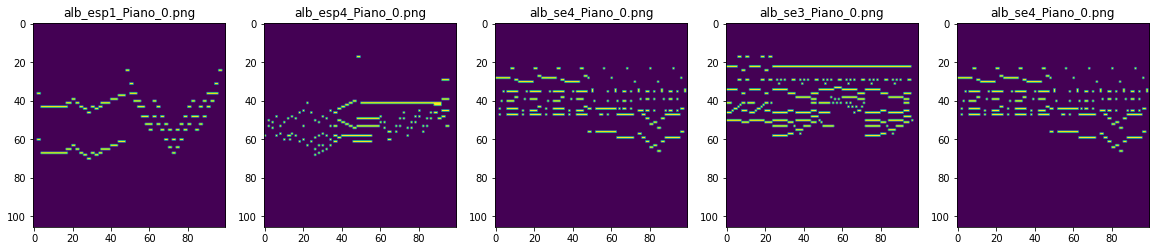

In [3]:
#@title Preview of the dataset (images shown represent Musical Instrument Digital Interface MIDI files - for more information check out the wikipedia page https://en.wikipedia.org/wiki/MIDI)
plt.figure(figsize=(20,20))
test_folder='./image_data/albeniz/'
for i in range(5):
    file = random.choice(os.listdir(test_folder))
    image_path= os.path.join(test_folder, file)
    img=mpimg.imread(image_path)
    ax=plt.subplot(1,5,i+1)
    ax.title.set_text(file)
    plt.imshow(img)

    
    

In [5]:
#@title Loading all images
def create_dataset(img_folder):
   
    img_data_array=[]
    class_name=[]
   
    for dir1 in os.listdir(img_folder):
        for file in os.listdir(os.path.join(img_folder, dir1)):
            image_path= os.path.join(img_folder,os.path.join(dir1, file))
            image = mpimg.imread(image_path)
            image=np.array(image)
            
            img_data_array.append(image)
            class_name.append(dir1)
    return img_data_array, class_name
# extract the image array and class name
img_data, class_name =create_dataset('./image_data/')

In [7]:
#@title making a dictionary for class names and their index
target_dict={k: v for v, k in enumerate(np.unique(class_name))}
target_val=  torch.tensor([target_dict[class_name[i]] for i in range(len(class_name))])

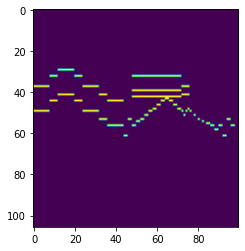

In [8]:
plt.imshow(img_data[0])

In [9]:
#@title Preprocessing the data
np_pil_im_arr=[]
for i in range(np.array(img_data).shape[0]):
  new_im = Image.fromarray(img_data[i])
  x=transforms.functional.pad(new_im,(28,22,0,0),fill=0)
  np_pil_im_arr.append(np.array(x))

img_data=np.resize(np_pil_im_arr,(295,1,128,128))

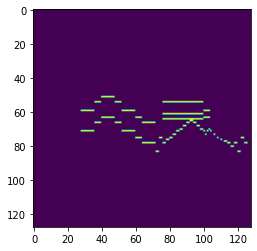

In [10]:
#@title View a sample of preprocessed image
plt.imshow(img_data[0][0])

In [11]:
#@title Creating the dataset
train_data = []
for i in range(len(img_data)):
    train_data.append([img_data[i], target_val[i]])

In [12]:
#@title Setting hyperparameters
g_lr = 0.02
d_lr = 0.00002
batch_size = 28
num_epochs = 170
n_class = 1

In [13]:
#@title Defining dataloaders

#train_set = MNIST(root='.', train=True, transform=trans, download=True)
train_loader = data_utils.DataLoader(train_data, batch_size=batch_size, shuffle=True)


In [14]:
#@title Defining helper functions 
def label2onehot(labels):
    uni_labels = np.unique(labels)
    k = 0
    dic = {}
    for l in uni_labels:
        dic[str(l.item())] = k
        k += 1
    onehot=[]
    for (i, l) in enumerate(labels):
        onehot.append( dic[str(l)])
    return onehot


def CrossEntropy_uniform(pred,batch_size,n_class):
    logsoftmax = nn.LogSoftmax(dim=1)
    invert = 1/n_class
    unif = torch.full((batch_size, n_class), invert ).to(device)
    inner = unif * logsoftmax(pred)
    outer = -torch.sum(inner, 1)
    result = torch.mean(outer) 
    return result

In [15]:
#@title Initializing the Generator and the Discriminator

n_class = 19
G = Generator().to(device)
D = Discriminator().to(device)

optim_G = torch.optim.Adam(G.parameters(), lr=g_lr, betas=(0.05, 0.999))
optim_D = torch.optim.Adam(D.parameters(), lr=d_lr, betas=(0.05, 0.999))

loss_f1 = nn.BCELoss()
loss_f2 = nn.CrossEntropyLoss()




In [16]:
#@title Loading pre-trained Unrolled Music Creative GAN
G.net[16]=nn.Sigmoid()
G.load_state_dict(torch.load("./G.pt",map_location=torch.device('cpu')))
G.eval()

Generator(
  (net): Sequential(
    (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, t

In [17]:
#@title Generate music (you can generate a different piece by running this again!)
from torchvision.utils import make_grid
noise = torch.randn(1, 100, device=device)
img_fake = G(noise)
img=img_fake[0,0,:,:].cpu().detach().numpy()
for i in range(128):
    for j in range(128):
        if img[i][j]>0.1:
            img[i][j]=255
        else:
            img[i][j]=0
plt.imshow(img)
plt.show()

#@title Save generated music
from PIL import Image
import numpy as np
from music21 import instrument, note, chord, stream

lowerBoundNote = 21
def column2notes(column):
    notes = []
    for i in range(len(column)):
        if column[i] >0:
            notes.append(i+lowerBoundNote)
    return notes

resolution = 0.25
def updateNotes(newNotes,prevNotes): 
    res = {} 
    for note in newNotes:
        if note in prevNotes:
            res[note] = prevNotes[note] + resolution
        else:
            res[note] = resolution
    return res

def image2midi(image):
    im_arr = np.flip(image, 0) #np.frombuffer(image.tobytes(), dtype=np.uint8)
    try:
        im_arr = im_arr.reshape((image.shape[0], image.shape[1]))
    except:
        im_arr = im_arr.reshape((image.shape[0], image.shape[1],3))
        im_arr = np.dot(im_arr, [0.33, 0.33, 0.33])

    """ convert the output from the prediction to notes and create a midi file
        from the notes """
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model

    prev_notes = updateNotes(im_arr.T[0,:],{})
    for column in im_arr.T[1:,:]:
        notes = column2notes(column)
        # pattern is a chord
        notes_in_chord = notes
        old_notes = prev_notes.keys()
        for old_note in old_notes:
            if not old_note in notes_in_chord:
                new_note = note.Note(old_note,quarterLength=prev_notes[old_note])
                new_note.storedInstrument = instrument.Piano()
                if offset - prev_notes[old_note] >= 0:
                    new_note.offset = offset - prev_notes[old_note]
                    output_notes.append(new_note)
                elif offset == 0:
                    new_note.offset = offset
                    output_notes.append(new_note)                    
                else:
                    print(offset,prev_notes[old_note],old_note)

        prev_notes = updateNotes(notes_in_chord,prev_notes)

        # increase offset each iteration so that notes do not stack
        offset += resolution

    for old_note in prev_notes.keys():
        new_note = note.Note(old_note,quarterLength=prev_notes[old_note])
        new_note.storedInstrument = instrument.Piano()
        new_note.offset = offset - prev_notes[old_note]

        output_notes.append(new_note)

    prev_notes = updateNotes(notes_in_chord,prev_notes)

    midi_stream = stream.Stream(output_notes)

    midi_stream.write('midi', fp="generated_creative.mid")

import sys
image2midi(img)

!fluidsynth -ni font.sf2 ./generated_creative.mid -F output.wav -r 44100
Audio('output.wav')

Output hidden; open in https://colab.research.google.com to view.

In [18]:
#@title Loading pre-trained Unrolled Music Creative GAN with hard sigmoid activation
G_h_s = Generator().to(device)
G_h_s.load_state_dict(torch.load("./G_hard_sigmoid.pt",map_location=torch.device('cpu')))
G_h_s.eval()

Generator(
  (net): Sequential(
    (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, t

In [19]:
#@title Generate music (again, you can generate a different piece by running this again!)
from torchvision.utils import make_grid
noise = torch.randn(1, 100, device=device)
img_fake = G_h_s(noise)
img=img_fake[0,0,:,:].cpu().detach().numpy()
for i in range(128):
    for j in range(128):
        if img[i][j]>0.1:
            img[i][j]=255
        else:
            img[i][j]=0

from PIL import Image
import numpy as np
from music21 import instrument, note, chord, stream

lowerBoundNote = 21
def column2notes(column):
    notes = []
    for i in range(len(column)):
        if column[i] >0:
            notes.append(i+lowerBoundNote)
    return notes

resolution = 0.25
def updateNotes(newNotes,prevNotes): 
    res = {} 
    for note in newNotes:
        if note in prevNotes:
            res[note] = prevNotes[note] + resolution
        else:
            res[note] = resolution
    return res

def image2midi(image):
    im_arr = np.flip(image, 0) #np.frombuffer(image.tobytes(), dtype=np.uint8)
    try:
        im_arr = im_arr.reshape((image.shape[0], image.shape[1]))
    except:
        im_arr = im_arr.reshape((image.shape[0], image.shape[1],3))
        im_arr = np.dot(im_arr, [0.33, 0.33, 0.33])

    """ convert the output from the prediction to notes and create a midi file
        from the notes """
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model

    prev_notes = updateNotes(im_arr.T[0,:],{})
    for column in im_arr.T[1:,:]:
        notes = column2notes(column)
        # pattern is a chord
        notes_in_chord = notes
        old_notes = prev_notes.keys()
        for old_note in old_notes:
            if not old_note in notes_in_chord:
                new_note = note.Note(old_note,quarterLength=prev_notes[old_note])
                new_note.storedInstrument = instrument.Piano()
                if offset - prev_notes[old_note] >= 0:
                    new_note.offset = offset - prev_notes[old_note]
                    output_notes.append(new_note)
                elif offset == 0:
                    new_note.offset = offset
                    output_notes.append(new_note)                    
                else:
                    print(offset,prev_notes[old_note],old_note)

        prev_notes = updateNotes(notes_in_chord,prev_notes)

        # increase offset each iteration so that notes do not stack
        offset += resolution

    for old_note in prev_notes.keys():
        new_note = note.Note(old_note,quarterLength=prev_notes[old_note])
        new_note.storedInstrument = instrument.Piano()
        new_note.offset = offset - prev_notes[old_note]

        output_notes.append(new_note)

    prev_notes = updateNotes(notes_in_chord,prev_notes)

    midi_stream = stream.Stream(output_notes)

    midi_stream.write('midi', fp="generated_creative.mid")

import sys
image2midi(img)
plt.imshow(img)
plt.show()
!fluidsynth -ni font.sf2 ./generated_creative.mid -F output.wav -r 44100
Audio('output.wav')

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#@title Training the model
device = torch.device("cuda" if torch.cuda.is_available()  else "cpu")
train_DCGAN(G, D, optim_G, optim_D, loss_f1, loss_f2, train_loader, num_epochs, 10,label2onehot, 
            CrossEntropy_uniform, n_class,
            device)